# Neural Networks: Multilayer Perceptron (MLP) with PyTorch

- Pytorch has a module called `nn` to help us build neural networks.

In [1]:
# for better image plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np

import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

from collections import OrderedDict

# Training the Neural Network
- **loss function:** identify how our network is performing 
    - Mean squared error (MSE):

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$


>   $n$: number of training samples
>
>   $y_i$ real labels
>
>   $\hat{y}_i$ estimated labels

- The network make some adjustments in the weights to minimize the Loss
- In order to find MIN(loss), we use _Gradient Descent_ 
- The gradient is the derivative vector 

## Autograd

- Now, let's use the _loss_ in backpropagation
- PyTorch has the module `autograd` that computes the gradientes
    - `autograd` stores the operations performed on each tensor
    - then passes it back calculating the gradients
    - Just to be sure that pytorch is actually sroting the operations, it's important to set `requires_grad = True` in the tensor
    - To do it so, we can call `requires_grad` or at any time write `x.requires_grad_(True)`

- It's also possible to deactivate the gradients calling `torch.no_grad()`:
- Also, we can turn it ON of OFF the storage of all gradients at the same time using `torch.set_grad_enabled(True|False)`.

- The gradients are related to a variable like `z`, with `z.backward()`

### Creating rando  numbers from a normal distribution with mean = `0` and variance = `1`:

In [29]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[ 1.3246,  0.6318],
        [-0.9723, -0.1335]], requires_grad=True)


In [30]:
y = x**2
print(y)

tensor([[1.7547, 0.3992],
        [0.9454, 0.0178]], grad_fn=<PowBackward0>)


- PowBackward0: it says that a squared operation created `y`

### The autograd module keeps track of these operations
- and knows how to compute the gradient of each one
- thus, it can compute the gradient for chain operations

### Computing the mean:

In [31]:
z = y.mean()
print(z)

tensor(0.7793, grad_fn=<MeanBackward0>)


In [32]:
print(x.grad)
print(y.grad)

None
None


<ipython-input-32-cd4c40187c02>:2: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print(y.grad)


### The proper way of computing the gradient is by executing the `.backward` in `z`
- This will compute the gradient of `z` related to `x`, like:

$$
\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}\left[\frac{1}{n}\sum_i^n x_i^2\right] = \frac{x}{2}
$$

In [33]:
z.backward()
print('\033[mGradient:\033[31m', x.grad)
print('\033[mx / 2:\033[31m', x/2)

Gradient: tensor([[ 0.6623,  0.3159],
        [-0.4862, -0.0667]])
x / 2: tensor([[ 0.6623,  0.3159],
        [-0.4862, -0.0667]], grad_fn=<DivBackward0>)


## Merging Loss and Autograd 
- When creating a network with pytorch, every parameter is initialized with `requires_grad = True`
- That means that when we call `loss.backward()`, the gradients of each parameter are calculated
- These gradients are used to update the weights during gradient descent
 
### Using _backward pass_:

In [34]:
# feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

In [35]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0023, -0.0023, -0.0023,  ..., -0.0023, -0.0023, -0.0023],
        [ 0.0034,  0.0034,  0.0034,  ...,  0.0034,  0.0034,  0.0034],
        [-0.0018, -0.0018, -0.0018,  ..., -0.0018, -0.0018, -0.0018],
        ...,
        [-0.0011, -0.0011, -0.0011,  ..., -0.0011, -0.0011, -0.0011],
        [ 0.0009,  0.0009,  0.0009,  ...,  0.0009,  0.0009,  0.0009],
        [-0.0063, -0.0063, -0.0063,  ..., -0.0063, -0.0063, -0.0063]])


## Training the Neural Network!
- The last key here, is to select the optimizer that will be uldating the weights with gradient
- There are some in the [`optim` package](https://pytorch.org/docs/stable/optim.html). 
- Let's try using the stochastic gradient descent (SGD) with `optim.SGD`

In [36]:
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

### Training:

* Forward 
* Use the output to compute the error (_loss_)
* Backward with `loss.backward()` to calculate the gradients
* Use the optimizer to update the weights

> Let's train the network and print the changes in the gradients;
>
> `optimizer.zero_grad()` at each iteration (because they accumulate at each backward);
>
> Knowing that, we must zero the grads at each iteration to avoid further accumulation.

In [37]:
print('\033[mInitial weights:\033[31m', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# zero the accumulated grads
optimizer.zero_grad()

# Forward, backward, and update the weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('\033[mGradient:\033[31m', model[0].weight.grad)

Initial weights: Parameter containing:
tensor([[-0.0099, -0.0259, -0.0350,  ...,  0.0052,  0.0235,  0.0288],
        [ 0.0228,  0.0031,  0.0300,  ..., -0.0120, -0.0298,  0.0330],
        [-0.0099, -0.0341, -0.0133,  ..., -0.0290, -0.0070, -0.0302],
        ...,
        [ 0.0299, -0.0346,  0.0083,  ..., -0.0146, -0.0193,  0.0106],
        [-0.0332,  0.0318,  0.0049,  ..., -0.0305, -0.0087, -0.0331],
        [ 0.0146,  0.0258,  0.0168,  ..., -0.0334,  0.0040,  0.0342]],
       requires_grad=True)
Gradient: tensor([[ 0.0032,  0.0032,  0.0032,  ...,  0.0032,  0.0032,  0.0032],
        [-0.0042, -0.0042, -0.0042,  ..., -0.0042, -0.0042, -0.0042],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        ...,
        [ 0.0010,  0.0010,  0.0010,  ...,  0.0010,  0.0010,  0.0010],
        [-0.0023, -0.0023, -0.0023,  ..., -0.0023, -0.0023, -0.0023],
        [ 0.0020,  0.0020,  0.0020,  ...,  0.0020,  0.0020,  0.0020]])


In [38]:
# Step that update the weights
optimizer.step()
print('\033[mUpdated weights:\033[31m', model[0].weight)

Updated weights: Parameter containing:
tensor([[-0.0099, -0.0259, -0.0350,  ...,  0.0051,  0.0234,  0.0288],
        [ 0.0228,  0.0032,  0.0300,  ..., -0.0120, -0.0298,  0.0331],
        [-0.0099, -0.0341, -0.0133,  ..., -0.0290, -0.0070, -0.0302],
        ...,
        [ 0.0299, -0.0347,  0.0083,  ..., -0.0146, -0.0193,  0.0106],
        [-0.0332,  0.0318,  0.0050,  ..., -0.0305, -0.0087, -0.0331],
        [ 0.0146,  0.0257,  0.0168,  ..., -0.0334,  0.0040,  0.0341]],
       requires_grad=True)


## Training: now it's for real!!!

- EPOCH: is when we pass through all samples
- Let's iterate through `trainloader` to use out training batches
- For each batch the error is calculated and the backpropagation step update the weights


In [39]:
## Sua solução vai aqui
# defining the model
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
# Criterion
criterion = nn.NLLLoss()
# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)


# TODO: defina o modelo, o critério e o atualizador

epochs = 5
for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
     
        # zero the accumulated grads
        optimizer.zero_grad()

        # Forward, backward, and update the weights
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.009742727983735
Training loss: 0.38593429581983
Training loss: 0.32734962540076995
Training loss: 0.29461358466159815
Training loss: 0.26883152753178247


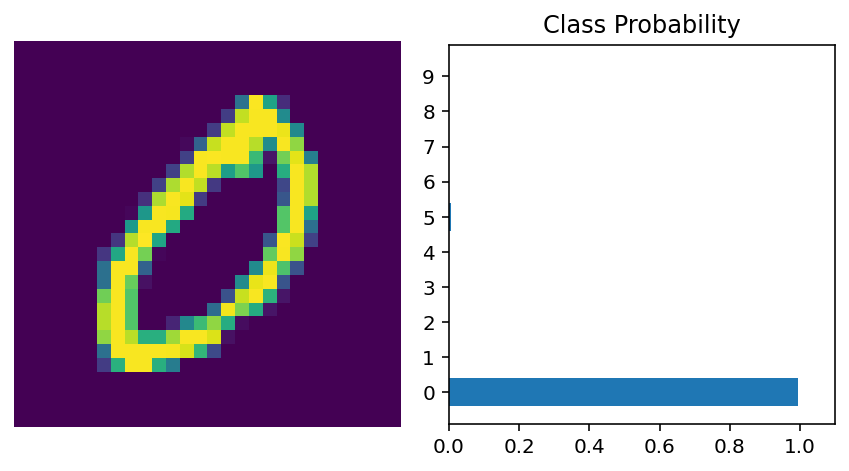

In [40]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# gradient OFF
with torch.no_grad():
    logps = model(img)

# We need the exp to see the real predictions
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

## GREAT! Our model works :)

# Creating a Neutal Network model from scratch
### 1) NeuralNetwork Class 
- inherits from the `nn.Module`
- `__init__` defines the layers: input, 2 hidden and output
- method `forward` receives x, flatten the tensor, passes the activation function (ReLU) for each layer, and the output layer is computed with `log_softmax`, passing the columns (dim=1).
### 2) NeuralNetwork_reg Class
- `__init__` defines the layers: input, 2 hidden and output; and defines the regularization `dropout` with probability of 0.2
- method `forward` receives x, flatten the tensor, passes the activation function (ReLU) inside the `dropout` regularization function (which will deactivate 20% of the neurons at each iteration, to help balance the weights properlly) for each layer, and the output layer is computed as before, passing the `log_softmax` (dim=1).

## Creating a function `model_pipeline` to evaluate different scenarios
1) transformations: 
    1) `ToTensor()` 
    
    2) `RandomHorizontalFlip`
    
     ![RandomHorizontalFlip](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_020.png)
     
    3) `RandomRotation` 
    
     ![RandomRotation](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_009.png)
     
    4) `RandomPerspective`
    
     ![RandomPerspective](https://pytorch.org/vision/stable/_images/sphx_glr_plot_transforms_008.png)

In [63]:
# NeuralNetwork class Inherit from nn.Module
## --> without regularization

class NeuralNetwork(nn.Module):
    def __init__(self): 
        super().__init__()
        # defining the layers and neurons
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # flattening the tensor
        x = x.view(x.shape[0], -1)
        # forward step
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [64]:
## ---> With regularization: Dropout

class NeuralNetwork_reg(nn.Module):
    def __init__(self): 
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # flattening the tensor
        x = x.view(x.shape[0], -1)
        # forward step
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [97]:
## ADDING a a new graph
def view_classify(img, ps, train_losses, test_losses, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12,6), nrows=1, ncols=3)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST" or "KMNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "FashionMNIST":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
    # Graph of train and test losses
    ax3.plot(train_losses, label = 'Train Loss')
    ax3.plot(test_losses, label = 'Test Loss')
    ax3.legend()
    
    plt.tight_layout()

In [98]:
def model_pipeline(dataset = 'KMNIST', horizontal_flip=False, flip_percentage=0.5,              # transformations
                   random_rotation=False, rotation_degree=20, 
                   random_perspective=False, distortion_scale=0.6, 
                   validation_size=0.2, reg=False, loss = 'cross', optimizer = 'adam',   # model parameters
                   batch_size=200, epochs = 5, lr_rate=0.002):                            
    
    """This function builds and trains a neural network model.
    ---> dataset: downloads the training and test sets dependind on the dataset passed as a string.
         - options: 'KMNIST', 'MNIST', 'FashionMNIST'; (). 
    ---> Transforms:
        1) horizontal_flip: True or False (default = False).
        - flip_percentage: probability of the image being flipped (default = 0.5).
        2) random_rotation: True or False (default = False).
        - rotation_degree: degree that the image will rotate (default = 20).
        3) random_perspective: True or False (default = False).
        - distortion_scale: argument to control the degree of distortion and ranges from 0 to 1 (default = 0.6).
   ---> Model, Loss and Optimizer:
        4) validation_size: size of the train samples that will be used to validate the model (default = 0.2).
        5) reg: True or False (default = False)| If the model will be defined with or without regularization.
        6) Loss functions: passed as a string. Options: "cross", "poiss", "gauss", "nll".
        7) Optimizer functions: passed as a string. Options: "adam", "adamax", "asgd".
   ---> Other parameters:
        8) batch_size: number of batches to pass into the dataloader (default = 200).
        9) epochs: defining the number of epochs (default = 5).
        10) lr_rate: the rate that the SGD will learn and reduce the loss function (default = 0.002).
        """ 
    ### creating transform pipeline
    if horizontal_flip:
        transformations = transforms.Compose([transforms.RandomHorizontalFlip(flip_percentage)])
    if random_rotation:
        transformations = transforms.Compose([transforms.RandomRotation(rotation_degree)])
    if random_perspective:
        transformations = transforms.Compose([transforms.RandomPerspective(distortion_scale)])

    transformations = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))])
    
    ### Downloading the training and test data dependind on the dataset variable passed as a string
    if dataset == 'KMNIST':
        train_dataset = datasets.KMNIST('./data', download=True, train=True, transform=transformations)
        test_dataset = datasets.KMNIST('./data/', download=True, train=False, transform=transformations)
    elif dataset == 'MNIST':
        train_dataset = datasets.MNIST('./data', download=True, train=True, transform=transformations)
        test_dataset = datasets.MNIST('./data/', download=True, train=False, transform=transformations)
    elif dataset == 'FashionMNIST':
        train_dataset = datasets.FashionMNIST('./data', download=True, train=True, transform=transformations)
        test_dataset = datasets.FashionMNIST('./data/', download=True, train=False, transform=transformations)
    
    # Get the size of our train set
    training_size = len(train_dataset)

    # then, we create a list of indices from 0 to training size range
    indices = list(range(training_size))

    # Shuffling the indices
    np.random.shuffle(indices)

    # The shuffled index will split the validation and training datasets using numpy "floor" method:
    index_split = int(np.floor(training_size * validation_size))  # floor of the scalar `x` is the largest integer

    # Then, we get the training and validation set indices passing the index split 
    validation_indices, training_indices = indices[:index_split], indices[index_split:]

    # Using SubsetRandomSampler we sample elements randomly from a list of indices
    training_sample = SubsetRandomSampler(training_indices)
    validation_sample = SubsetRandomSampler(validation_indices)
   
    ### creating the data loader, passing the sampler created above
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=training_sample)
    valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=validation_sample)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    ### defining the model with or without regularization
    if reg:       # if True the model will be instantiated with regularization (dropout)
        model = NeuralNetwork_reg()
    elif reg == False:         # if False, the model won't have regularization
        model = NeuralNetwork()
        
    ### LOSS
    if loss == 'cross':
        criterion = nn.CrossEntropyLoss() 
    elif loss == 'poiss':
        criterion = nn.PoissonNLLLoss()
    elif loss == 'gauss':
        criterion = nn.GaussianNLLLoss()
    elif loss == 'nll':
        criterion = nn.NLLLoss()
    
    ### OPTIMIZER
    if optimizer == 'adam':    
        optimizer = optim.Adam(model.parameters(), lr=lr_rate)
    if optimizer == 'adamax': 
        optimizer = optim.Adamax(model.parameters(), lr=lr_rate)
    if optimizer == 'asgd': 
        optimizer = optim.ASGD(model.parameters(), lr=lr_rate)
    
    ### Training the NN
    train_losses, test_losses = [], []
    for e in range(epochs):
        running_loss = 0
        for image, label in train_loader:
            optimizer.zero_grad()
            log_ps = model(image)
            loss = criterion(log_ps, label)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        else:
            test_loss = 0
            accuracy = 0
            with torch.no_grad():
                model.eval()
                for image, label in test_loader:         
                    log_ps = model.forward(image)
                    prob = torch.exp(log_ps)
                    test_loss+= criterion(log_ps, label)
                    k_prob, k_class = prob.topk(1, dim=1)
                    equals = k_class == label.view(*k_class.shape)
                    accuracy+= torch.mean(equals.type(torch.FloatTensor))
            model.train()
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training Loss: {:.3f}...".format(train_losses[-1]),
              "Test Loss: {:.3f}...".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
        
    ### Showing the image and the probability barplot   
    images, labels = next(iter(train_loader))

    img = images[0].view(1, 784)
    # gradient OFF
    with torch.no_grad():
        logps = model(img)

    # We need the exp to see the real predictions
    ps = torch.exp(logps)
    view_classify(img.view(1, 28, 28), ps, train_losses, test_losses, version=dataset)
    
    return (accuracy/len(test_loader)), train_losses, test_losses

In [7]:
def create_dataset(dataset='KMNIST'):
#         ### Downloading the training and test data dependind on the dataset variable passed as a string
#         if dataset == 'KMNIST':
    if dataset=='KMNIST':
        X = KMNIST
    train_dataset = datasets.f'{X}'('./data', download=True, train=True, transform=transformations)
    test_dataset = datasets.f'{X}'('./data/', download=True, train=False, transform=transformations)
#         elif dataset == 'MNIST':
#             train_dataset = datasets.MNIST('./data', download=True, train=True, transform=transformations)
#             test_dataset = datasets.MNIST('./data/', download=True, train=False, transform=transformations)
#         elif dataset == 'FashionMNIST':
#             train_dataset = datasets.FashionMNIST('./data', download=True, train=True, transform=transformations)
#             test_dataset = datasets.FashionMNIST('./data/', download=True, train=False, transform=transformations

SyntaxError: invalid syntax (<ipython-input-7-10b07e1a150e>, line 6)

In [6]:
create_dataset()

AttributeError: module 'torchvision.datasets' has no attribute 'dataset'

## Testing the classes and the function with KMNIST:

Epoch: 1/10... Training Loss: 0.694... Test Loss: 0.759... Test Accuracy: 0.755
Epoch: 2/10... Training Loss: 0.332... Test Loss: 0.617... Test Accuracy: 0.810
Epoch: 3/10... Training Loss: 0.243... Test Loss: 0.517... Test Accuracy: 0.840
Epoch: 4/10... Training Loss: 0.185... Test Loss: 0.463... Test Accuracy: 0.863
Epoch: 5/10... Training Loss: 0.148... Test Loss: 0.434... Test Accuracy: 0.874
Epoch: 6/10... Training Loss: 0.120... Test Loss: 0.438... Test Accuracy: 0.882
Epoch: 7/10... Training Loss: 0.097... Test Loss: 0.420... Test Accuracy: 0.886
Epoch: 8/10... Training Loss: 0.081... Test Loss: 0.448... Test Accuracy: 0.882
Epoch: 9/10... Training Loss: 0.065... Test Loss: 0.449... Test Accuracy: 0.887
Epoch: 10/10... Training Loss: 0.055... Test Loss: 0.489... Test Accuracy: 0.876


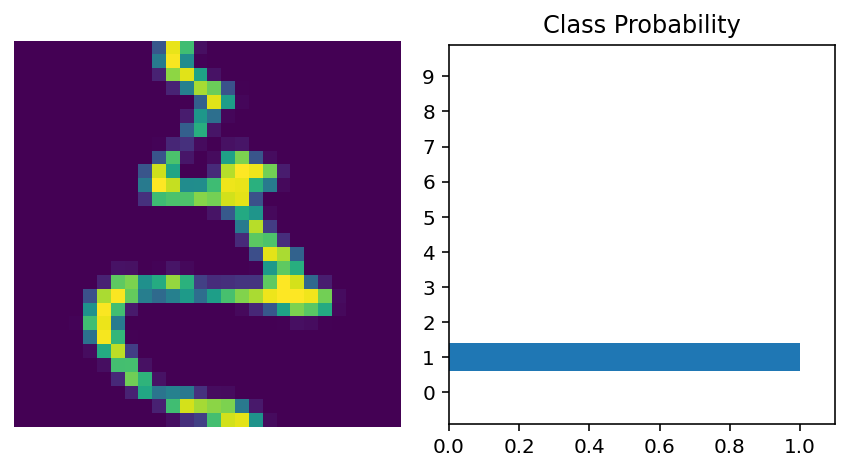

In [68]:
acc, train_loss, test_loss = model_pipeline(random_perspective=True, distortion_scale=0.8, optimizer='adamax', epochs=10, lr_rate=0.002)

## Testing the classes and the function with MNIST:

Epoch: 1/5... Training Loss: 0.618... Test Loss: 0.489... Test Accuracy: 0.820
Epoch: 2/5... Training Loss: 0.424... Test Loss: 0.458... Test Accuracy: 0.835
Epoch: 3/5... Training Loss: 0.381... Test Loss: 0.411... Test Accuracy: 0.850
Epoch: 4/5... Training Loss: 0.349... Test Loss: 0.386... Test Accuracy: 0.858
Epoch: 5/5... Training Loss: 0.329... Test Loss: 0.366... Test Accuracy: 0.867


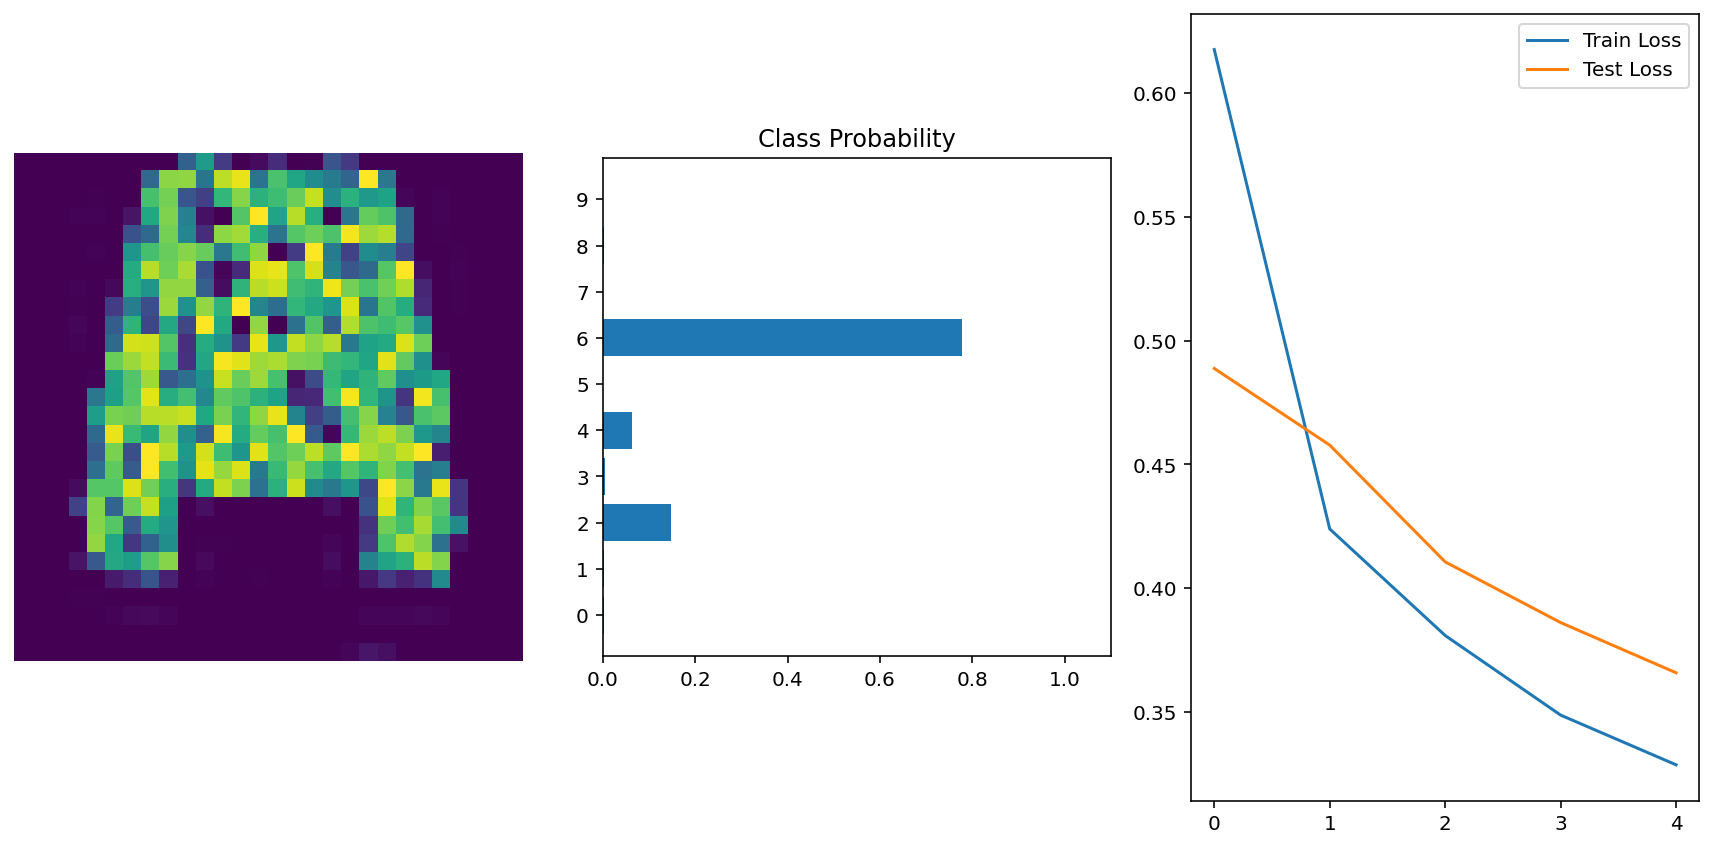

In [99]:
acc, train_loss, test_loss = model_pipeline(dataset='FashionMNIST', random_perspective=True, distortion_scale=0.8, optimizer='adamax')

In [ ]:
acc, train_loss, test_loss = model_pipeline(dataset='FashionMNIST', random_perspective=True, distortion_scale=0.8, optimizer='adamax', epochs=10, lr_rate=0.002)